In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.stats import norm

#define subfunctions

def StockPriceTree(parameters):

    # initial states
    S0 = parameters['model']['S0']
    
    # parameters
    u = parameters['model']['u']
    d = parameters['model']['d']    
    
    # total nodes
    N = parameters['setup']['N']
    M = N + 1  # starting from t=0
    
    # stock prices at maturity
    STs = np.zeros(M) #terminal stock price
    for i in range(M): #i is downward jumps, in [0,N]
        #print(i)
        STs[i] = S0*u**(N-i)*d**i  # ** means power of
       #print(STs[i])
        
    return STs

def PayoffTree(STs, parameters):
    
    # option info
    K = parameters['asset']['K'] 
    option_type = parameters['asset']['optype'] 
    
    payoffs = np.maximum(0, (STs- K) if option_type == 1 else (K-STs))
    
    return payoffs


def BinomialTreePrice(payoffs, parameters):
    
    # calcuate discounted payoff at each node at maturity
    rf = parameters['model']['rf']
    T = parameters['setup']['T']       
    DF = np.exp(-rf*T)
    
    u = parameters['model']['u']
    d = parameters['model']['d']    
    
    qu = parameters['model']['q']
    qd = 1 - qu
    
    N = parameters['setup']['N']     
    discountpayoffs = np.zeros(N+1)
    node_probs = np.zeros(N+1)
    
    for i in range(N+1): 
        prob_i = comb(N, N-i)*qu**(N-i)*qd**i
        node_probs[i] = prob_i
        discountpayoffs[i] = DF*payoffs[i]*node_probs[i]
        
    price = np.sum(discountpayoffs)
    
    return price, discountpayoffs, node_probs

def Black_ScholesPrice(parameters):

    S0 = parameters['model']['S0']
    sigma = parameters['model']['sigma']
    K = parameters['asset']['K'] 
    rf = parameters['model']['rf']
    T = parameters['setup']['T']    
    option_type = parameters['asset']['optype'] 
    
    DF = np.exp(-rf*T)
    
    d1 = (np.log(S0/K)+(rf+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 1:  # call
        option_price = S0 * norm.cdf(d1) - K * DF * norm.cdf(d2)
    elif option_type == -1: # put
        option_price = K * DF * norm.cdf(-d2) - S0 * norm.cdf(-d1) 
    
    return option_price

def BinomialTreevsBS(parameters):
    # stock tree
    stocks = StockPriceTree(parameters)
    stocks_df = pd.DataFrame(stocks, index =list(range(0,parameters['setup']['N']+1)), columns=['stockprice'])
    #print(stocks_df)
    
    # option payoffs
    payoffs = PayoffTree(stocks, parameters)
    payoffs_df = pd.DataFrame(payoffs, index =list(range(0,parameters['setup']['N']+1)), columns=['payoffs'])
    #print(payoffs_df)
    
    # price 
    [option_price_BT, discountpayoffs, node_probs] = BinomialTreePrice(payoffs, parameters)   
    dispayoffs_df = pd.DataFrame(discountpayoffs, index =list(range(0,parameters['setup']['N']+1)), columns=['disc_payoffs'])
    node_probs_df = pd.DataFrame(node_probs, index =list(range(0,parameters['setup']['N']+1)), columns=['node_probs'])
    
    # output & save files    
    binomial_all = pd.concat([stocks_df, payoffs_df, dispayoffs_df,node_probs_df],axis=1)
    #print(binomial_all)      
    #print(option_price_BT)
    
    option_price_BS = Black_ScholesPrice(parameters)
    print('Price_BT= %f vs Price_BS =%f\n'%(option_price_BT, option_price_BS))
    
    #binomial_all.to_excel(r"binomial_all.xlsx")
    
    #plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)#1x2 plot
    #plt.xticks(arange(len(stocks_df)),stocks_df)
    plt.plot(stocks, payoffs, 'b')
    plt.grid(True)
    plt.xlabel('S(T)')
    plt.ylabel('max(S(T)-K,0)')
    
    plt.subplot(1,2,2)
    plt.plot(stocks, node_probs, 'r')
    plt.grid(True)
    plt.xlabel('S(T)')
    plt.ylabel('Density of S(T)')
    
    plt.tight_layout()
    plt.show()
    
    #return stocks_df, payoffs_df, node_probs   

def PriceDifferencebyUs(parameters):
    
    u_set = np.linspace(1.02,1.50,num = 20)
    n = len(u_set)
    parameters_ex2 = parameters;
    price_set = np.zeros((n,2),dtype = float)
    for i in range(0,n):
        parameters_ex2['model']['u'] = u_set[i] 
        parameters_ex2['model']['d'] = 1/u_set[i]
        parameters_ex2['model']['q'] = (np.exp(rf*dt)-parameters_ex2['model']['d'])/(parameters_ex2['model']['u']-parameters_ex2['model']['d'])
        
        stocks_ex2 = StockPriceTree(parameters_ex2)
        payoffs_ex2 = PayoffTree(stocks_ex2, parameters_ex2)
        price_bt_ex2,_,_ = BinomialTreePrice(payoffs_ex2, parameters_ex2)   
        price_bs_ex2 = Black_ScholesPrice(parameters_ex2)
        #print(u_set[i])
        #print(1/u_set[i])
        #print(parameters_ex2['model']['q'])
        #print(price_bt_ex2)
        
        price_set[i][0] = price_bt_ex2
        price_set[i][1] = price_bs_ex2
        #print(price_set[i][0])
    
    #price_u_df = pd.DataFrame(price_set, index =list(range(0,n)),  columns=['price_bt', 'price_bs'])
    price_u_df = pd.DataFrame(price_set, index = u_set,  columns=['price_bt', 'price_bs'])
    print(price_u_df)
    
    price_u_df.to_excel(r"price_u_df.xlsx")
    
    #plot
    plt.figure(figsize=(12,4))    
    plt.plot(u_set, price_u_df['price_bt'], 'b')
    plt.plot(np.transpose(u_set), price_u_df['price_bs'], 'r.')
    plt.grid(True)
    plt.xlabel('u')
    plt.ylabel('Option prices')
    
    plt.tight_layout()
    plt.show()
    
    #return price_u_df, u_set    

    
def PriceDifferencebyDt(parameters_ex3):
    N_set = [20, 40, 100, 200, 300, 400, 600, 800, 1000] #np.linspace(40,200,num = 10)
    #print(N_set)
    n = len(N_set)
    price_set = np.zeros((n,2),dtype = float)
    for i in range(0,n):
        parameters_ex3['setup']['N'] = int(N_set[i])
        dt_i = parameters_ex3['setup']['T']/parameters_ex3['setup']['N']
        parameters_ex3['setup']['dt'] = dt_i 
        
        parameters_ex3['model']['u'] = np.exp(sigma*np.sqrt(dt_i))
        parameters_ex3['model']['d'] = np.exp(-sigma*np.sqrt(dt_i))
        parameters_ex3['model']['q'] = (np.exp(rf*dt_i)-parameters_ex3['model']['d'])/(parameters_ex3['model']['u']-parameters_ex3['model']['d'])
        #print(parameters_ex3)
        
        stocks_ex3 = StockPriceTree(parameters_ex3)
        payoffs_ex3 = PayoffTree(stocks_ex3, parameters_ex3)
        price_bt_ex3,_,_ = BinomialTreePrice(payoffs_ex3, parameters_ex3)   
        price_bs_ex3 = Black_ScholesPrice(parameters_ex3)
        #print(N_set[i])
        #print(1/u_set[i])
        #print(parameters_ex3['setup']['dt'])
        #print(price_bt_ex3)
        
        price_set[i][0] = price_bt_ex3
        price_set[i][1] = price_bs_ex3
        
    
    #price_dt_df = pd.DataFrame(price_set, index =list(range(0,n)),  columns=['price_bt', 'price_bs'])
    price_dt_df = pd.DataFrame(price_set, index = N_set,  columns=['price_bt', 'price_bs'])
    print(price_dt_df)
    
    price_dt_df.to_excel(r"price_dt_df.xlsx")
    
    #plot
    plt.figure(figsize=(12,4))    
    plt.plot(N_set, price_dt_df['price_bt'], 'b.')
    plt.plot(np.transpose(N_set), price_dt_df['price_bs'], 'r')
    plt.grid(True)
    plt.xlabel('N')
    plt.ylabel('Option prices')
    
    plt.tight_layout()
    plt.show()
    
    #return price_dt_df     
#main function
#u,d,q

{'model': {'S0': 100, 'sigma': 0.2, 'rf': 0.05, 'u': 1.032, 'd': 0.9689922480620154, 'q': 0.5119772174280662}, 'asset': {'K': 100, 'optype': 1}, 'setup': {'T': 1, 'N': 40, 'dt': 0.025}}
Price_BT= 10.371485 vs Price_BS =10.450584



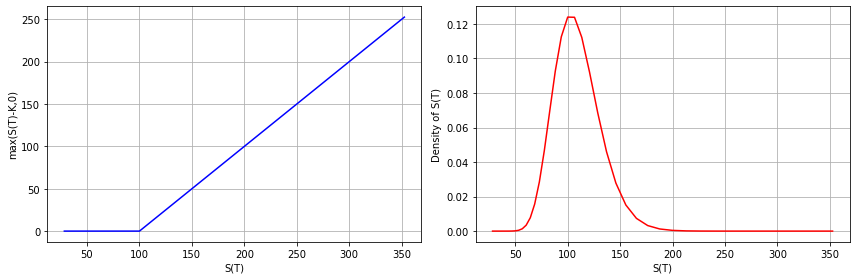

           price_bt   price_bs
1.020000   7.660026  10.450584
1.045263  13.403132  10.450584
1.070526  19.091312  10.450584
1.095789  24.587801  10.450584
1.121053  29.857896  10.450584
1.146316  34.884876  10.450584
1.171579  39.659572  10.450584
1.196842  44.177604  10.450584
1.222105  48.438195  10.450584
1.247368  52.443453  10.450584
1.272632  56.197819  10.450584
1.297895  59.707622  10.450584
1.323158  62.980681  10.450584
1.348421  66.025968  10.450584
1.373684  68.853308  10.450584
1.398947  71.473115  10.450584
1.424211  73.896174  10.450584
1.449474  76.133448  10.450584
1.474737  78.195920  10.450584
1.500000  80.094464  10.450584


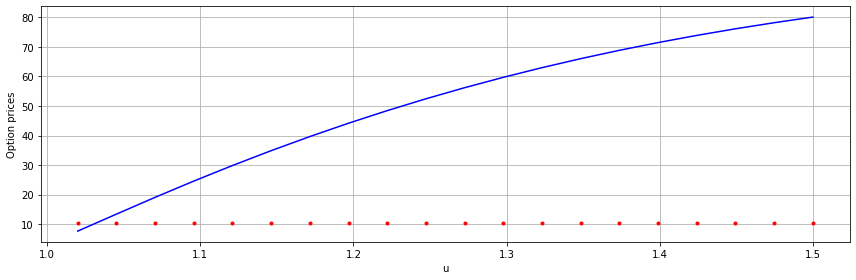

       price_bt   price_bs
20    10.351260  10.450584
40    10.400751  10.450584
100   10.430612  10.450584
200   10.440591  10.450584
300   10.443921  10.450584
400   10.445586  10.450584
600   10.447251  10.450584
800   10.448084  10.450584
1000  10.448584  10.450584


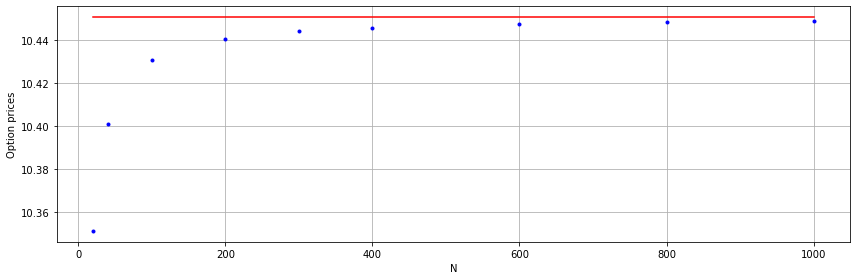

In [32]:
if __name__=="__main__": # main function
    
    S0 = 100
    sigma = 0.20
    K = 100
    rf = 0.05    
    T = 1     # maturity
    
    # discrete setup
    N = 40  # steps
    dt = T/N
    
    #by matching up two moments
    u_req = np.exp(sigma*np.sqrt(dt))
    d_req = 1/u_req
    q_req = (np.exp(rf*dt)-d_req)/(u_req-d_req)
    
    #step1: construction o fbinomial tree for stock price
    
    #step2: work out option prices, based on probs at maturity T
    
    u = 1.032
    d= 1/u
    q = (np.exp(rf*dt)-d)/(u-d)
    
    # required stepup
    #print('current setup =(u=%f, d=%f, q=%f)\n'%(u,d,q))
    #print('required setup =(u=%f, d=%f, q=%f)\n'%(u_req, d_req,q_req))
    
    Optype = 1 # 1: call -1: put
    
    #build a dictionary with 3 chapters(models)
    parameters_ex1 = {'model':{'S0':S0, 'sigma':sigma, 'rf':rf, 'u':u, 'd':d, 'q':q},                 
                  'asset':{'K':K, 'optype': Optype},
                  'setup':{'T':T, 'N':N, 'dt': T/N}                
                 }
    print(parameters_ex1)
#     #To disable, ctrl+/    
#     # Exam 1: price_BT vs price_VS     
#     print(StockPriceTree(parameters_ex1))
#     #[stocks_df, payoffs_df, node_probs] =  BinomialTreevsBS(parameters)
    
#     ST = StockPriceTree(parameters_ex1) #stock price
#     print(ST)
#     Payoff = PayoffTree(ST, parameters_ex1) #terminal payoff of the option
#     #print(Payoff)
    
#     #option price
#     op_bi, discountpayoffs, node_probs = BinomialTreePrice(Payoff,parameters_ex1)
#     print(op_bi)
    BinomialTreevsBS(parameters_ex1)
    
    parameters_ex2 = {'model':{'S0':S0, 'sigma':sigma, 'rf':rf, 'u':u, 'd':d, 'q':q},                 
                  'asset':{'K':K, 'optype': Optype},
                  'setup':{'T':T, 'N':N, 'dt': T/N}
                 }# test 2
    
    # Exam 2: price comparison across different us   
    PriceDifferencebyUs(parameters_ex2)
    #[price_u_df, u_set] = PriceDifferencebyUs(parameters)
    
    
    parameters_ex3 = {'model':{'S0':S0, 'sigma':sigma, 'rf':rf, 'u':u, 'd':d, 'q':q},                 
                  'asset':{'K':K, 'optype': Optype},
                  'setup':{'T':T, 'N':N, 'dt': T/N}
                 }# test 3
    
    # Exam 3: convergency of option prices over different dt
    PriceDifferencebyDt(parameters_ex3)
    #[price_dt_df] = PriceDifferencebyDt(parameters_ex3)